# Data Preparation and descriptive statistics

## Importing consumption data

In [100]:
import pandas as pd
df = pd.read_csv("ProductionConsumptionSettlement.csv", delimiter=";")

# Convert columns to appropriate data types
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK'] = pd.to_datetime(df['HourDK'])

## Lil bit of data cleaning/prep

In [103]:
# Convert columns to numeric format (replacing commas with dots)
columns_to_convert = ['CentralPowerMWh', 'LocalPowerMWh',
                      'CommercialPowerMWh', 'LocalPowerSelfConMWh', 'OffshoreWindLt100MW_MWh',
                      'OffshoreWindGe100MW_MWh', 'OnshoreWindLt50kW_MWh',
                      'OnshoreWindGe50kW_MWh', 'HydroPowerMWh', 'SolarPowerLt10kW_MWh',
                      'SolarPowerGe10Lt40kW_MWh', 'SolarPowerGe40kW_MWh',
                      'SolarPowerSelfConMWh', 'UnknownProdMWh', 'ExchangeNO_MWh',
                      'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh',
                      'ExchangeGreatBelt_MWh', 'GrossConsumptionMWh',
                      'GridLossTransmissionMWh', 'GridLossInterconnectorsMWh',
                      'GridLossDistributionMWh', 'PowerToHeatMWh']

df[columns_to_convert] = df[columns_to_convert].apply(lambda x: x.str.replace(',', '.')).astype(float)

df['Wind'] = df[['OffshoreWindLt100MW_MWh', 'OffshoreWindGe100MW_MWh', 'OnshoreWindLt50kW_MWh', 'OnshoreWindGe50kW_MWh']].sum(axis=1)
df['Hydro'] = df['HydroPowerMWh']
df['Solar'] = df[['SolarPowerLt10kW_MWh', 'SolarPowerGe10Lt40kW_MWh', 'SolarPowerGe40kW_MWh', 'SolarPowerSelfConMWh']].sum(axis=1)
df['Power'] = df[['CentralPowerMWh', 'LocalPowerMWh', 'CommercialPowerMWh', 'LocalPowerSelfConMWh']].sum(axis=1)
df['Exchange'] = df[['CentralPowerMWh', 'LocalPowerMWh', 'CommercialPowerMWh', 'LocalPowerSelfConMWh']].sum(axis=1)


# Rename nd drops
df.rename(columns={'UnknownProdMWh': 'Unknown_Production'}, inplace=True)

df.drop(['OffshoreWindLt100MW_MWh', 'OffshoreWindGe100MW_MWh', 'OnshoreWindLt50kW_MWh', 'OnshoreWindGe50kW_MWh',
         'HydroPowerMWh', 'SolarPowerLt10kW_MWh', 'SolarPowerGe10Lt40kW_MWh', 'SolarPowerGe40kW_MWh', 'SolarPowerSelfConMWh',
         'CentralPowerMWh', 'LocalPowerMWh', 'CommercialPowerMWh', 'LocalPowerSelfConMWh'], axis=1, inplace=True)

df = df[['HourUTC', 'HourDK', 'PriceArea', 'Wind', 'Hydro', 'Solar', 'Power', 'Unknown_Production',
         'ExchangeNO_MWh', 'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh',
         'ExchangeGreatBelt_MWh', 'GrossConsumptionMWh', 'GridLossTransmissionMWh', 'GridLossInterconnectorsMWh',
         'GridLossDistributionMWh', 'PowerToHeatMWh']]

## fill Exhcnage NAn with 0 
df[['ExchangeNO_MWh','ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh', 'ExchangeGreatBelt_MWh']] = df[['ExchangeNO_MWh','ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh', 'ExchangeGreatBelt_MWh']].fillna(0)

# Merge the exchanges -- net exchange ish --- CHECK IF THIS IS OK --- ALSO GET BACK TO EXHCANGE GREAT BELT
df['Exchange'] = df[['ExchangeNO_MWh','ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh']].sum(axis=1)
exchange_columns = ['ExchangeNO_MWh', 'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh']
df[exchange_columns] = df[exchange_columns].fillna(0)


df['GridLoss'] = df[['GridLossTransmissionMWh', 'GridLossInterconnectorsMWh', 'GridLossDistributionMWh','PowerToHeatMWh']].sum(axis=1)
grid_loss_columns = ['GridLossTransmissionMWh', 'GridLossInterconnectorsMWh', 'GridLossDistributionMWh', 'PowerToHeatMWh']
df['GridLoss'] = df[grid_loss_columns].sum(axis=1)

## finally drop the columns:
df.drop(['ExchangeNO_MWh', 'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh', 'GridLossTransmissionMWh', 'GridLossInterconnectorsMWh',
         'GridLossDistributionMWh', 'PowerToHeatMWh'], axis=1, inplace=True)

## Now onto weather data

In [104]:
import requests
import pandas as pd

#data collected from https://open-meteo.com/ --- code is inspired from documentation

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": 56.2639,  # Latitude of Denmark
    "longitude": 9.5018,  # Longitude of Denmark
    "start_date": "2022-01-01",
    "end_date": "2024-03-01",
	"hourly": ["temperature_2m", "precipitation", "cloud_cover", "wind_speed_10m"],
	"wind_speed_unit": "ms",
	"timezone": "Europe/Berlin"
}


# Make the HTTP request
response = requests.get(url, params=params)
data = response.json()

# Process hourly data. The order of variables needs to be the same as requested.
hourly = data['hourly']
hourly_temperature_2m = hourly['temperature_2m']
hourly_precipitation = hourly['precipitation']
hourly_cloud_cover = hourly['cloud_cover']
hourly_wind_speed_10m = hourly['wind_speed_10m']

df_weather = pd.DataFrame()
df_weather['Datetime'] = pd.to_datetime(hourly['time'])
df_weather['hourly_temperature_2m'] = hourly_temperature_2m #°C
df_weather['precipitation'] = hourly_precipitation #mm
df_weather['cloud_cover'] = hourly_cloud_cover #% of sky
df_weather['hourly_wind_speed_10m'] = hourly_wind_speed_10m #already in m/s      #[speed/3.6 for speed in hourly_wind_speed_10m] #km/h to m/s

# df_weather.head()

In [105]:
# Merge the DataFrames on 'HourDK' and 'Datetime'
merged_df = pd.merge(df, df_weather, left_on='HourDK', right_on='Datetime', how='left')
merged_df.drop('Datetime', axis=1, inplace=True)

missing_values_exist = False

for column in merged_df.columns:
    num_missing = merged_df[column].isnull().sum()
    if num_missing > 0:
        missing_values_exist = True
        print(f"Column '{column}' has {num_missing} missing values.")

if not missing_values_exist:
    print("No missing vlaues found.")


#!!!!!!!! Remove rows where PriceArea == 'DK1'
merged_df_DK1 = merged_df[merged_df['PriceArea'] != 'DK2']
merged_df_DK2 = merged_df[merged_df['PriceArea'] != 'DK1']



merged_df_DK1.head(2)
merged_df_DK1.describe()

No missing vlaues found.


,HourUTC,HourDK,Wind,Hydro,Solar,Power,Unknown_Production,ExchangeGreatBelt_MWh,GrossConsumptionMWh,Exchange,GridLoss,hourly_temperature_2m,precipitation,cloud_cover,hourly_wind_speed_10m
count,18960,18960,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000
mean,2023-01-30 22:30:00,2023-01-31 00:02:57.721518848,1660.624711,2.146363,220.149608,831.214784,0.058473,-0.640153,2598.753557,-114.800230,323.233667,8.657078,0.108486,59.599736,4.320082
min,2021-12-31 23:00:00,2022-01-01 00:00:00,0.821767,0.084128,0.052065,111.388990,0.000000,-605.700000,1460.655524,-3204.469108,114.372566,-13.000000,0.000000,0.000000,0.000000
25%,2022-07-17 10:45:00,2022-07-17 12:45:00,558.582047,1.182360,0.184747,476.733112,0.000014,-299.025000,2220.891603,-849.942500,190.528539,3.800000,0.000000,23.000000,2.750000
50%,2023-01-30 22:30:00,2023-01-30 23:30:00,1451.593129,1.861568,5.324500,678.285237,0.028042,-0.300000,2605.209496,-42.530000,245.113270,8.200000,0.000000,68.000000,4.050000
75%,2023-08-16 10:15:00,2023-08-16 12:15:00,2566.271837,2.990048,276.965405,1061.682403,0.099400,303.600000,2945.405372,678.048425,399.809874,13.800000,0.000000,100.000000,5.590000
max,2024-02-29 22:00:00,2024-02-29 23:00:00,4825.248284,5.555328,1994.581960,2695.634735,0.936407,590.500000,4040.558877,2495.900000,1075.440288,32.200000,8.300000,100.000000,13.970000
std,NaN,NaN,1235.971708,1.101743,382.758363,482.921318,0.076109,364.367113,497.204147,1046.197978,184.245745,6.639388,0.382470,38.508783,2.057996


When modelling Denmark we have two areas, DK1 and DK2. DK1 being west Denmark. 

It gets complex to model the interactions between these two areas as 'one' system due to their energy exchange, as such we only model one of the DK areas and treat the other as an exchange later when we do modelling. <-- this is not completely set up in the code, but we will do descriptive stats on one of the areas:

In [106]:
merged_df_DK1.head(3)

,HourUTC,HourDK,PriceArea,Wind,Hydro,Solar,Power,Unknown_Production,ExchangeGreatBelt_MWh,GrossConsumptionMWh,Exchange,GridLoss,hourly_temperature_2m,precipitation,cloud_cover,hourly_wind_speed_10m
0,2021-12-31 23:00:00,2022-01-01 00:00:00,DK1,2055.764409,1.637731,0.074532,609.812186,0.0,385.2,2196.288858,-856.20,360.817724,7.0,0.0,100,4.14
2,2022-01-01 00:00:00,2022-01-01 01:00:00,DK1,2039.635142,1.641966,0.068892,550.685591,0.0,356.5,2206.261591,-742.27,417.870739,7.4,0.0,100,4.10
4,2022-01-01 01:00:00,2022-01-01 02:00:00,DK1,1940.061145,1.637933,0.068020,639.051325,0.0,293.3,2147.808423,-726.31,413.053915,6.9,0.0,100,3.98


## Descriptive stats

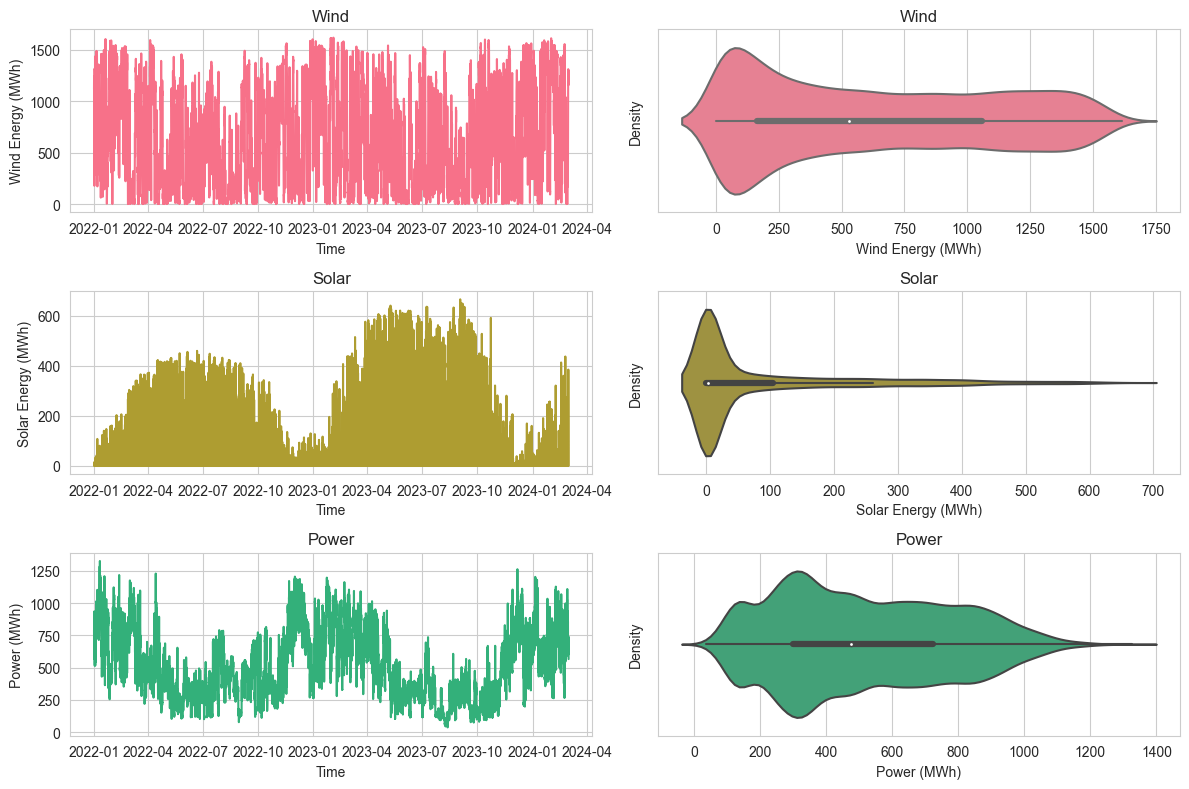

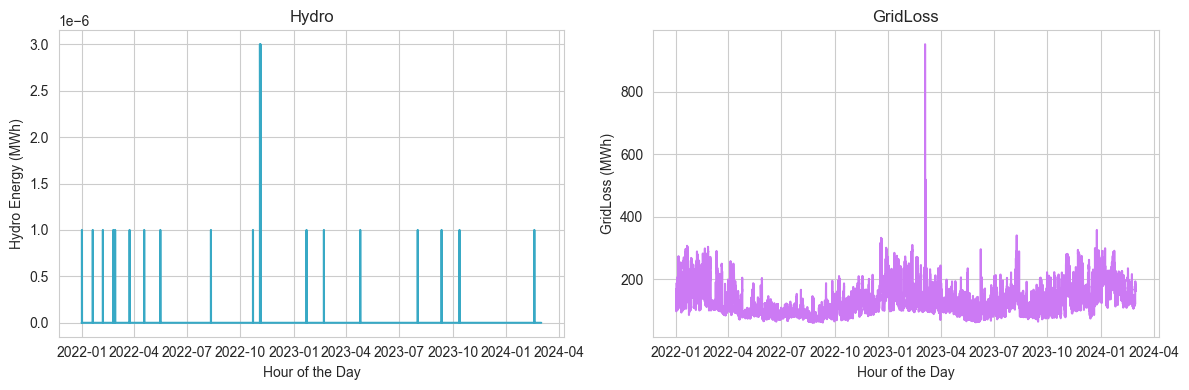

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 8))

# Set seaborn style
sns.set_style("whitegrid")

# Set colors for plots
colors = sns.color_palette("husl", 5)

# Define hours of the day
hours = np.arange(1, 25)

# Calculate average energy and standard deviation for each hour
wind_avg = []
wind_std = []
solar_avg = []
solar_std = []
power_avg = []
power_std = []

for hour in hours:
    wind_hourly = merged_df_DK2[merged_df_DK2['HourDK'].dt.hour == hour]['Wind']
    solar_hourly = merged_df_DK2[merged_df_DK2['HourDK'].dt.hour == hour]['Solar']
    power_hourly = merged_df_DK2[merged_df_DK2['HourDK'].dt.hour == hour]['Power']
    
    wind_avg.append(wind_hourly.mean())
    wind_std.append(wind_hourly.std())
    
    solar_avg.append(solar_hourly.mean())
    solar_std.append(solar_hourly.std())
    
    power_avg.append(power_hourly.mean())
    power_std.append(power_hourly.std())

# Plot Wind, Solar, and Power
plt.subplot(3, 2, 1)
plt.plot(merged_df_DK2['HourDK'], merged_df_DK2['Wind'], color=colors[0], label='Line Plot')
plt.title('Wind')
plt.xlabel('Time')
plt.ylabel('Wind Energy (MWh)')
# plt.legend()

plt.subplot(3, 2, 2)
sns.violinplot(x=merged_df_DK2['Wind'], color=colors[0])
plt.title('Wind')
plt.xlabel('Wind Energy (MWh)')
plt.ylabel('Density')

plt.subplot(3, 2, 3)
plt.plot(merged_df_DK2['HourDK'], merged_df_DK2['Solar'], color=colors[1], label='Line Plot')
plt.title('Solar')
plt.xlabel('Time')
plt.ylabel('Solar Energy (MWh)')
# plt.legend()

plt.subplot(3, 2, 4)
sns.violinplot(x=merged_df_DK2['Solar'], color=colors[1])
plt.title('Solar')
plt.xlabel('Solar Energy (MWh)')
plt.ylabel('Density')

plt.subplot(3, 2, 5)
plt.plot(merged_df_DK2['HourDK'], merged_df_DK2['Power'], color=colors[2], label='Line Plot')
plt.title('Power')
plt.xlabel('Time')
plt.ylabel('Power (MWh)')
# plt.legend()

plt.subplot(3, 2, 6)
sns.violinplot(x=merged_df_DK2['Power'], color=colors[2])
plt.title('Power')
plt.xlabel('Power (MWh)')
plt.ylabel('Density')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Subplot for Hydro and GridLoss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(merged_df_DK2['HourDK'], merged_df_DK2['Hydro'], color=colors[3], label='Hydro')
plt.title('Hydro')
plt.xlabel('Hour of the Day')
plt.ylabel('Hydro Energy (MWh)')
# plt.legend()

plt.subplot(1, 2, 2)
plt.plot(merged_df_DK2['HourDK'], merged_df_DK2['GridLoss'], color=colors[4], label='GridLoss')
plt.title('GridLoss')
plt.xlabel('Hour of the Day')
plt.ylabel('GridLoss (MWh)')
# plt.legend()

plt.tight_layout()
plt.show()




From this we can get an initial overview of the distributions of the energy. Especially that wind greatly fluctuates, but produces quite a large amount of power.

Solar power is cyclical especially during the 'summer' periods, but also has a large amount of down-time (we can also see this in the next plots)

Additionally, power is a pretty stable power production and never reaches 0 

Lastly Hydro is sparcely used, and barely produces anything, thus we may need to consider removing it. Additionally, grid loss amounts for a non-negligible power 'user'

Next we can plot the hourly development, also including the weather data: 

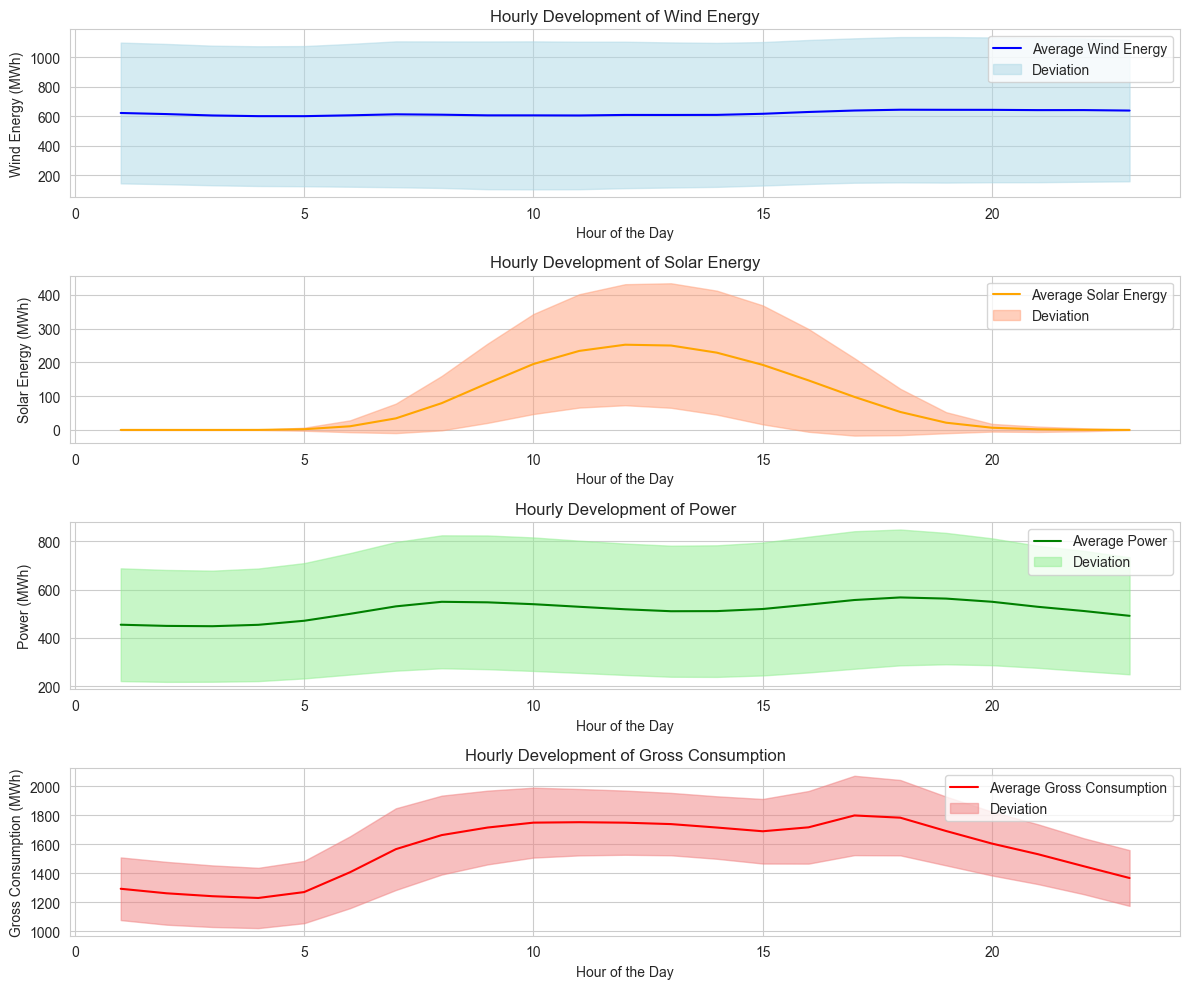

In [107]:
import numpy as np

plt.figure(figsize=(12, 10))

# Set seaborn style
sns.set_style("whitegrid")

# Define hours of the day
hours = np.arange(1, 25)

# Calculate average energy and standard deviation for each hour
wind_avg = []
wind_std = []
solar_avg = []
solar_std = []
power_avg = []
power_std = []
consumption_avg = []
consumption_std = []

for hour in hours:
    wind_hourly = merged_df_DK2[merged_df_DK2['HourDK'].dt.hour == hour]['Wind']
    solar_hourly = merged_df_DK2[merged_df_DK2['HourDK'].dt.hour == hour]['Solar']
    power_hourly = merged_df_DK2[merged_df_DK2['HourDK'].dt.hour == hour]['Power']
    consumption_hourly = merged_df_DK2[merged_df_DK2['HourDK'].dt.hour == hour]['GrossConsumptionMWh']
    
    wind_avg.append(wind_hourly.mean())
    wind_std.append(wind_hourly.std())
    
    solar_avg.append(solar_hourly.mean())
    solar_std.append(solar_hourly.std())
    
    power_avg.append(power_hourly.mean())
    power_std.append(power_hourly.std())
    
    consumption_avg.append(consumption_hourly.mean())
    consumption_std.append(consumption_hourly.std())

# Plot Wind
plt.subplot(4, 1, 1)
plt.plot(hours, wind_avg, color='blue', label='Average Wind Energy')
plt.fill_between(hours, np.array(wind_avg) - np.array(wind_std), np.array(wind_avg) + np.array(wind_std), color='lightblue', alpha=0.5, label='Deviation')
plt.title('Hourly Development of Wind Energy')
plt.xlabel('Hour of the Day')
plt.ylabel('Wind Energy (MWh)')
plt.legend()

# Plot Solar
plt.subplot(4, 1, 2)
plt.plot(hours, solar_avg, color='orange', label='Average Solar Energy')
plt.fill_between(hours, np.array(solar_avg) - np.array(solar_std), np.array(solar_avg) + np.array(solar_std), color='lightsalmon', alpha=0.5, label='Deviation')
plt.title('Hourly Development of Solar Energy')
plt.xlabel('Hour of the Day')
plt.ylabel('Solar Energy (MWh)')
plt.legend()

# Plot Power
plt.subplot(4, 1, 3)
plt.plot(hours, power_avg, color='green', label='Average Power')
plt.fill_between(hours, np.array(power_avg) - np.array(power_std), np.array(power_avg) + np.array(power_std), color='lightgreen', alpha=0.5, label='Deviation')
plt.title('Hourly Development of Power')
plt.xlabel('Hour of the Day')
plt.ylabel('Power (MWh)')
plt.legend()

# Plot Gross Consumption
plt.subplot(4, 1, 4)
plt.plot(hours, consumption_avg, color='red', label='Average Gross Consumption')
plt.fill_between(hours, np.array(consumption_avg) - np.array(consumption_std), np.array(consumption_avg) + np.array(consumption_std), color='lightcoral', alpha=0.5, label='Deviation')
plt.title('Hourly Development of Gross Consumption')
plt.xlabel('Hour of the Day')
plt.ylabel('Gross Consumption (MWh)')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


From the above plots, we can especially see the time dependence of solar energy. Additionally, the general power plants don't largely vary, but their average does seem to be multimodal around peak times. Possibly to anticipate peak demand around those times.

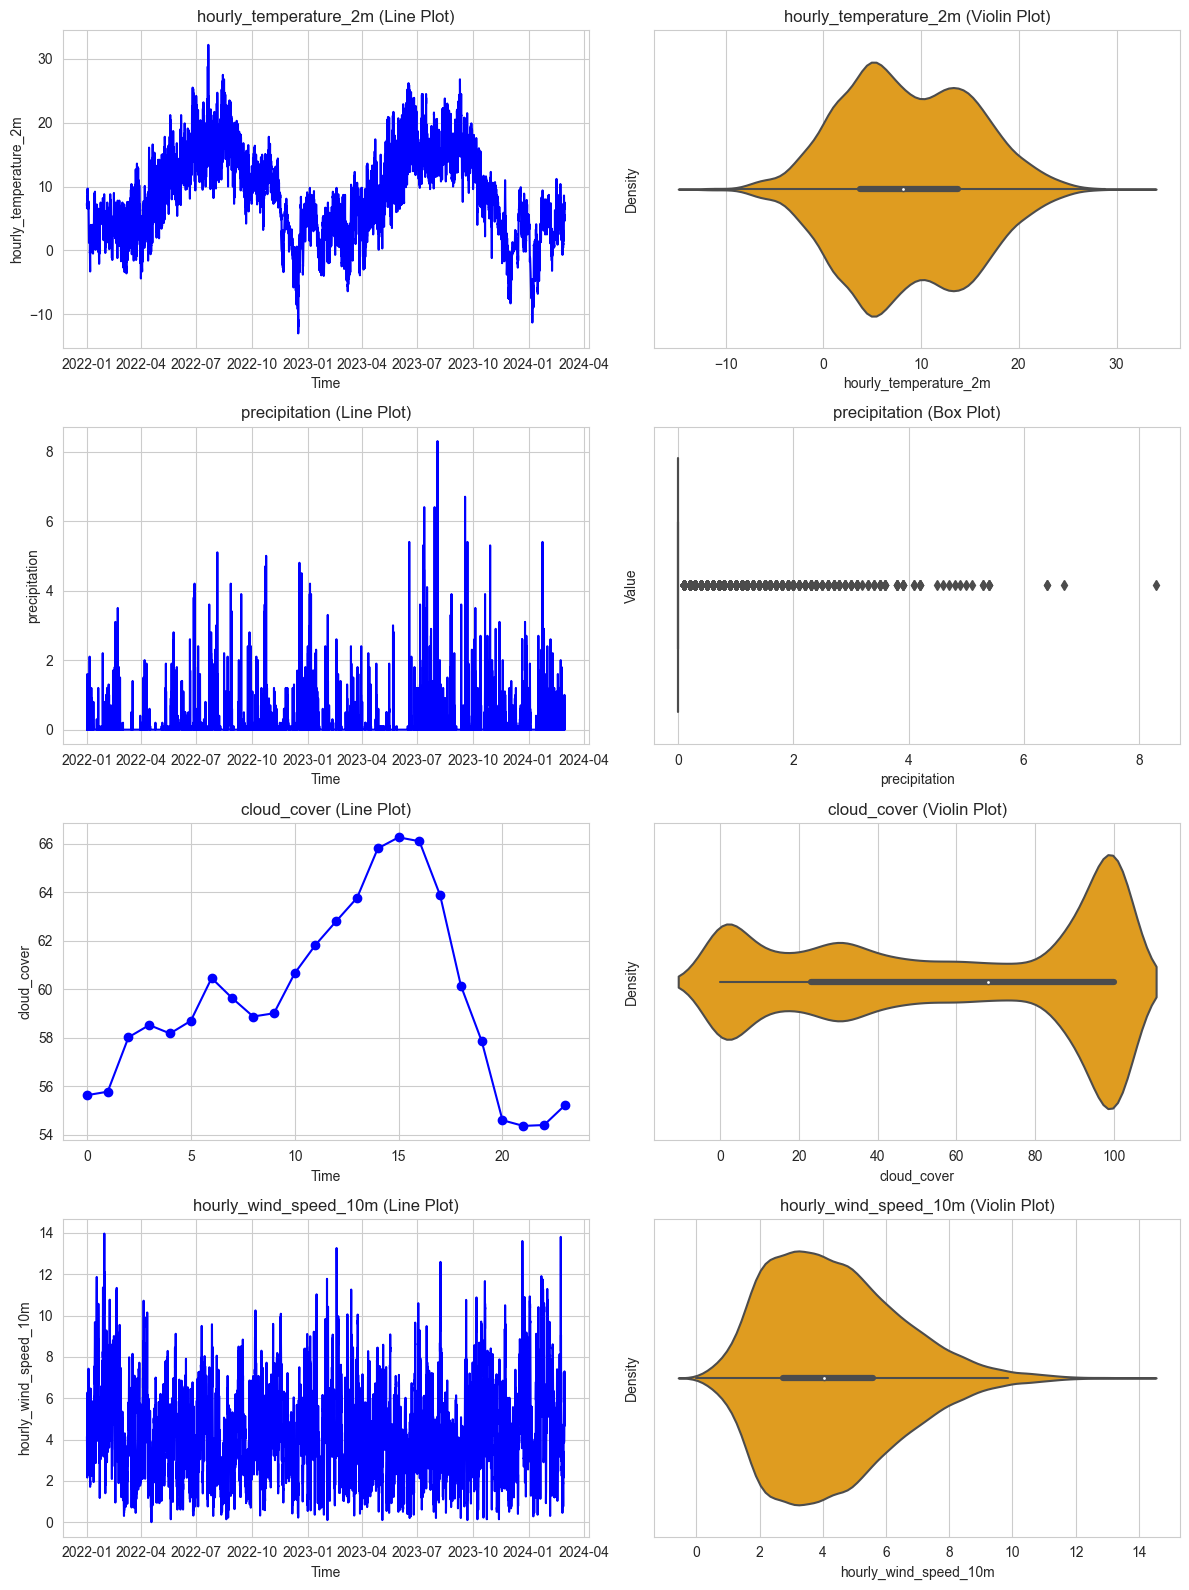

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axes with subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Set seaborn style
sns.set_style("whitegrid")

# Define variables
variables = ['hourly_temperature_2m', 'precipitation', 'cloud_cover', 'hourly_wind_speed_10m']

# Plot line plot on the left and box plot on the right for each variable
for i, variable in enumerate(variables):
    if variable == 'cloud_cover':
        hourly_bins = merged_df_DK1.groupby(merged_df_DK1['HourDK'].dt.hour)[variable].mean()
        axs[i, 0].plot(hourly_bins.index, hourly_bins, color='blue', marker='o')
        axs[i, 0].set_title(f'{variable} (Line Plot)')
    else:
        axs[i, 0].plot(merged_df_DK1['HourDK'], merged_df_DK1[variable], color='blue')
        axs[i, 0].set_title(f'{variable} (Line Plot)')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel(variable)
    
    if variable == 'precipitation':
        sns.boxplot(x=merged_df_DK1[variable], ax=axs[i, 1], color='orange')
        axs[i, 1].set_title(f'{variable} (Box Plot)')
        #this took too long ;(
    else:
        sns.violinplot(x=merged_df_DK1[variable], ax=axs[i, 1], color='orange')
        axs[i, 1].set_title(f'{variable} (Violin Plot)')
    axs[i, 1].set_xlabel(variable)
    axs[i, 1].set_ylabel('Density' if variable != 'precipitation' else 'Value')

plt.tight_layout()
plt.show()


With regards to the weather data shown above, we can see that they are both dependent on the time of day and season, but also exhibit some degree of randomness such as with or precipitation

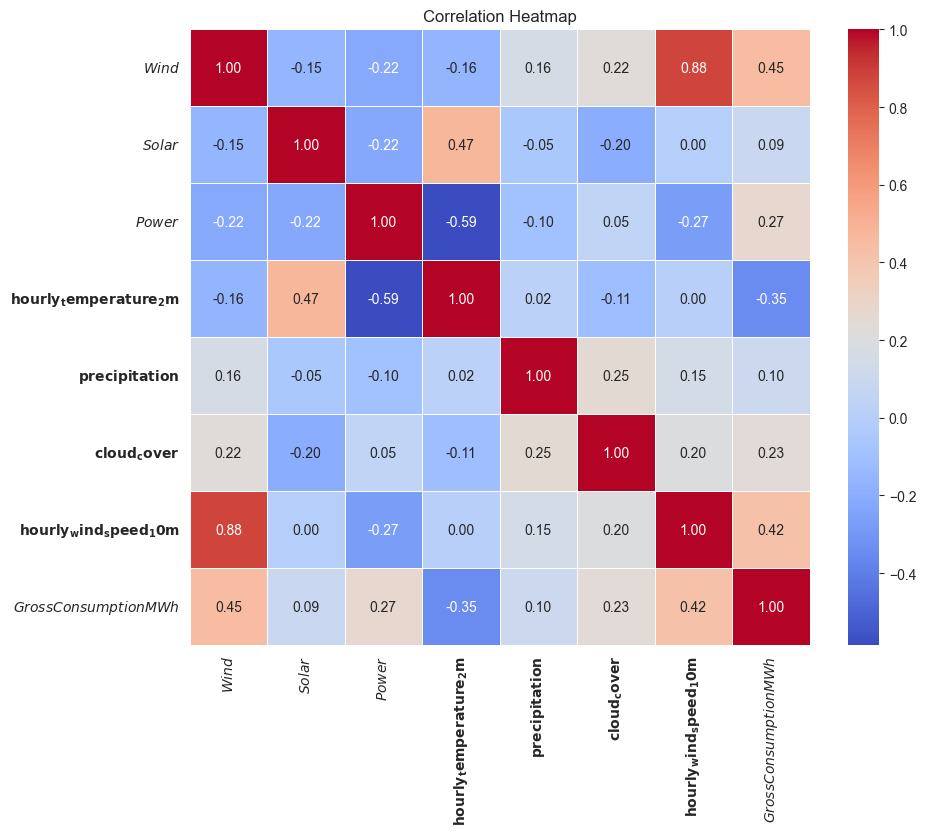

In [116]:
correlation_matrix = merged_df_DK1[['Wind', 'Solar', 'Power', 'hourly_temperature_2m', 'precipitation', 'cloud_cover', 'hourly_wind_speed_10m','GrossConsumptionMWh']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
weather_features = ['hourly_temperature_2m', 'precipitation', 'cloud_cover', 'hourly_wind_speed_10m']
ax = plt.gca()
ax.set_xticklabels([f'$\mathbf{{{label}}}$' if label in weather_features else f'${label}$' for label in correlation_matrix.columns])
ax.set_yticklabels([f'$\mathbf{{{label}}}$' if label in weather_features else f'${label}$' for label in correlation_matrix.index])

plt.title('Correlation Heatmap')
plt.show()


The above also highlights the assumption of the weather having an influence on the power production, as well as on the consumption. Supporting the PGM we formulated

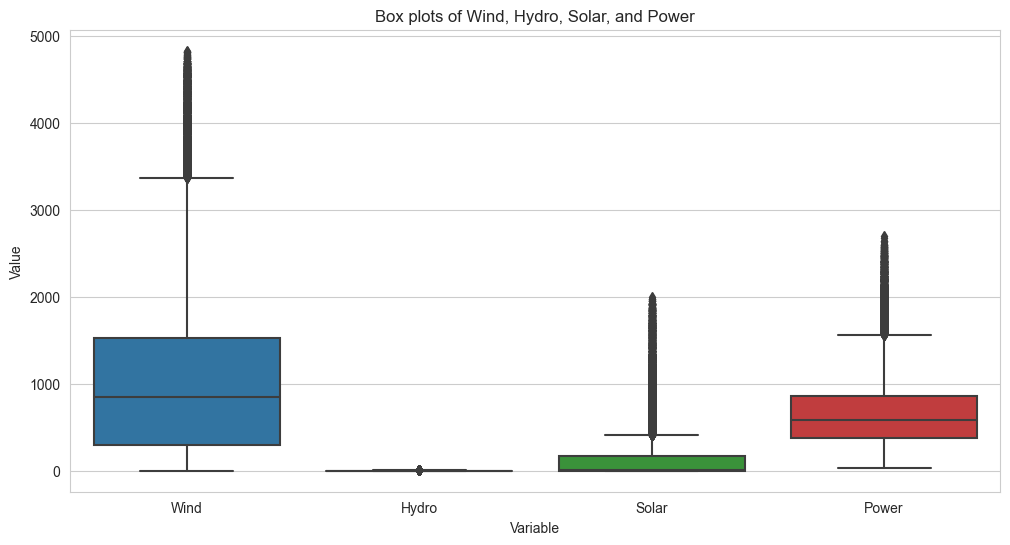

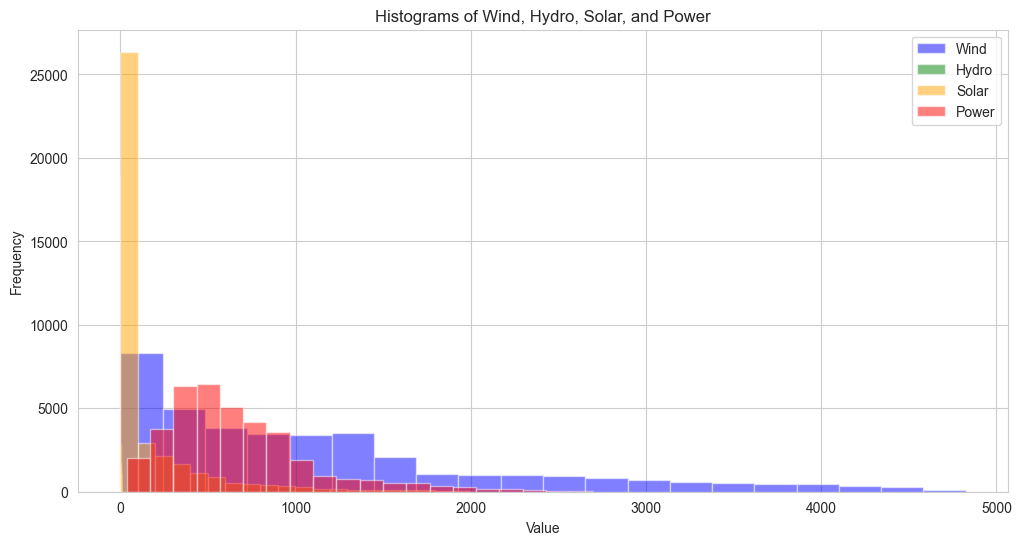

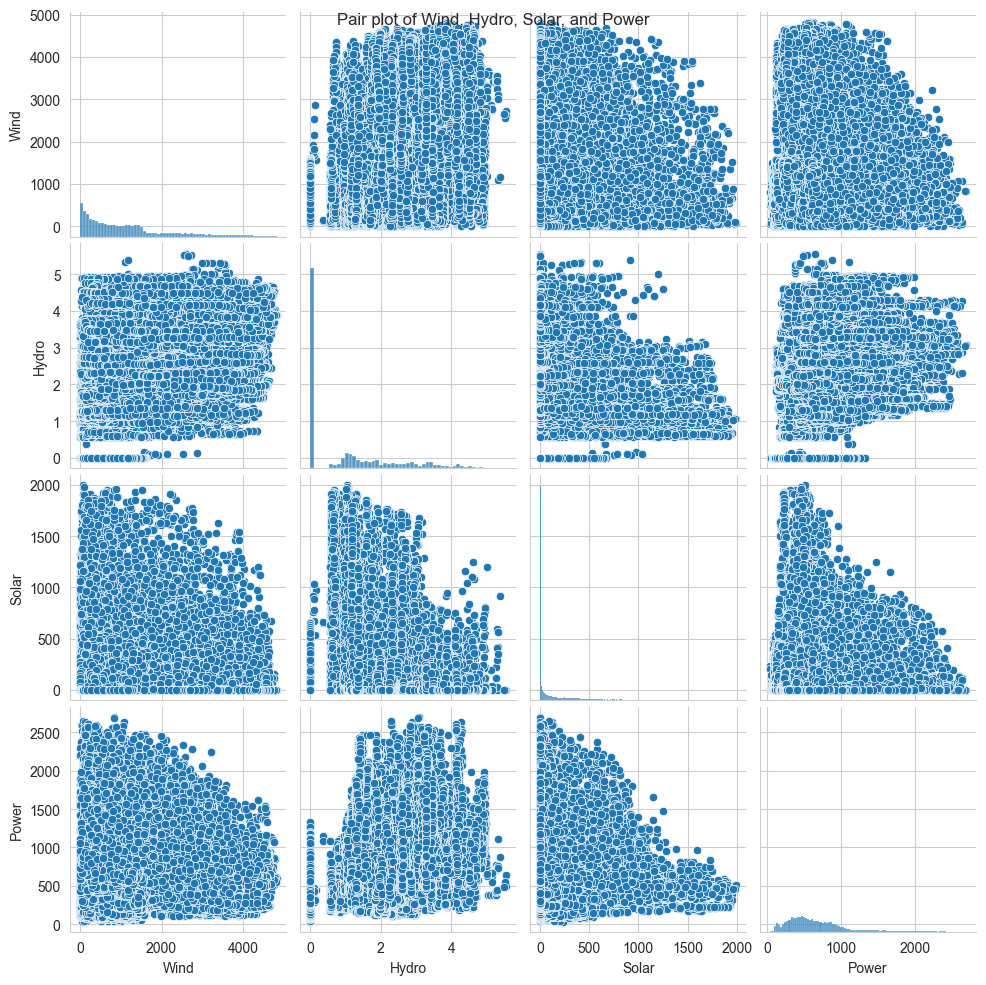

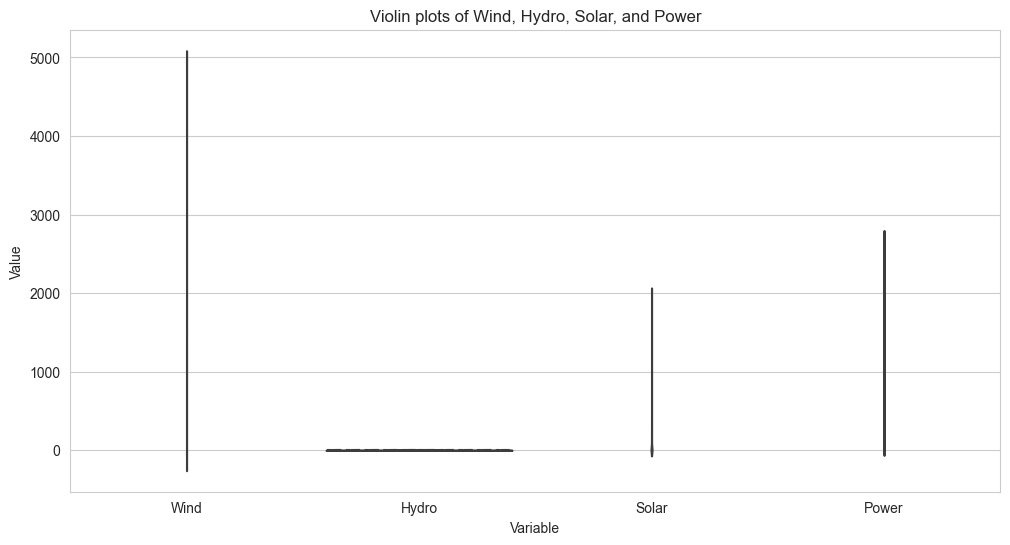

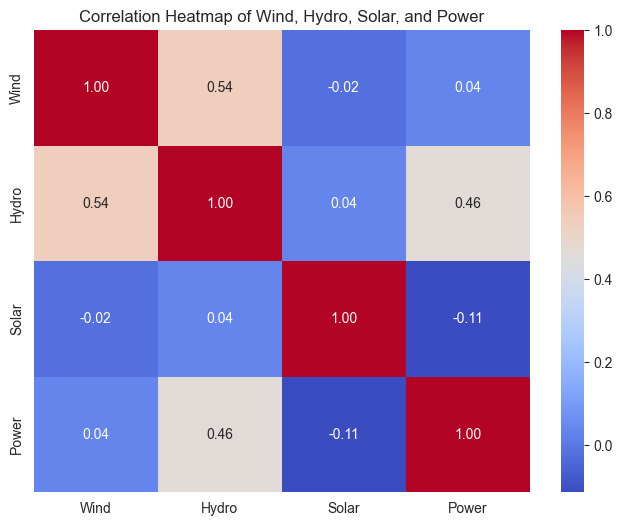

               Wind         Hydro         Solar         Power
count  37920.000000  37920.000000  37920.000000  37920.000000
mean    1140.808708      1.073181    150.678872    672.108465
std     1073.597292      1.326142    295.988591    420.134355
min        0.020450      0.000000      0.016974     36.676712
25%      291.935784      0.000000      0.153508    381.040192
50%      850.741258      0.042065      3.096282    578.057520
75%     1522.059775      1.861547    165.183564    853.506216
max     4825.248284      5.555328   1994.581960   2695.634735


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create box plots for Wind, Hydro, Solar, Power
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Wind', 'Hydro', 'Solar', 'Power']])
plt.title('Box plots of Wind, Hydro, Solar, and Power')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Wind', 'Hydro', 'Solar', 'Power'])
plt.show()

# Create histograms for Wind, Hydro, Solar, Power
plt.figure(figsize=(12, 6))
plt.hist(df['Wind'], bins=20, alpha=0.5, label='Wind', color='blue')
plt.hist(df['Hydro'], bins=20, alpha=0.5, label='Hydro', color='green')
plt.hist(df['Solar'], bins=20, alpha=0.5, label='Solar', color='orange')
plt.hist(df['Power'], bins=20, alpha=0.5, label='Power', color='red')
plt.title('Histograms of Wind, Hydro, Solar, and Power')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Create pair plot for Wind, Hydro, Solar, Power
sns.pairplot(df[['Wind', 'Hydro', 'Solar', 'Power']])
plt.suptitle('Pair plot of Wind, Hydro, Solar, and Power')
plt.show()

# Create violin plots for Wind, Hydro, Solar, Power
plt.figure(figsize=(12, 6))
sns.violinplot(data=df[['Wind', 'Hydro', 'Solar', 'Power']], inner='quartile')
plt.title('Violin plots of Wind, Hydro, Solar, and Power')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Wind', 'Hydro', 'Solar', 'Power'])
plt.show()

# Calculate correlation matrix
corr_matrix = df[['Wind', 'Hydro', 'Solar', 'Power']].corr()

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Wind, Hydro, Solar, and Power')
plt.show()

# Calculate summary statistics for Wind, Hydro, Solar, Power
summary_stats = df[['Wind', 'Hydro', 'Solar', 'Power']].describe()
print(summary_stats)


